<a href="https://colab.research.google.com/github/ahmedcs/Practical_FL_Tutorial/blob/main/notebooks/Attack_FL_IDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to Secure Federated Learning in Network Monitoring

In this part, we will examine the use of federated learning to train a collabrative intrusion detection system and show the impact of presence of malicious clients on federated intrusion detection systems.

We will use NSL-KDD, a commonly used (and sometimes criticized) dataset for training IDSs, and a simple neural network architecture to train our model. The IDS use case involves NIID data.

We will also see how FL can be used to *share knowledge* between different institutions, but we assume that an attacker is sending malicious updates to negatively impact the system. We will see how the system can be made more robust to such attacks using a modified aggregation algorithm called FoolsGold.

## Section 0: Prerequisites

### Dependencies

> Be advised that some packages required in these notebooks require Python 3.11 or higher.

Let's start by obtaining our dataset.


In [1]:
# check if we are running on Google Colab
import os
import sys

print("Python version: ", sys.version_info.major, ".", sys.version_info.minor)

from IPython.core.getipython import get_ipython

if not "google.colab" in str(get_ipython()):
    # cd to a temporary directory to avoid cluttering the current directory
    try:
        os.mkdir("/tmp/nslkdd")
    except FileExistsError:
        pass
    os.chdir("/tmp/nslkdd")

# download the dataset
if not os.path.exists("NSL-KDD/KDDTrain+.txt"):
    !curl -Lo nslkdd.zip "https://raw.githubusercontent.com/ahmedcs/Practical_FL_Tutorial/refs/heads/main/datasets/nslkdd.zip?download=true"
    !unzip -o nslkdd.zip && rm nslkdd.zip
else:
  print('Dataset files already exists')

Python version:  3 . 11
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6444k  100 6444k    0     0  6308k      0  0:00:01  0:00:01 --:--:-- 6311k
Archive:  nslkdd.zip
  inflating: NSL-KDD/KDDTest+.arff   
  inflating: NSL-KDD/KDDTest+.txt    
  inflating: NSL-KDD/KDDTest-21.arff  
  inflating: NSL-KDD/KDDTest-21.txt  
  inflating: NSL-KDD/KDDTest1.jpg    
  inflating: NSL-KDD/KDDTrain+.arff  
  inflating: NSL-KDD/KDDTrain+.txt   
  inflating: NSL-KDD/KDDTrain+_20Percent.arff  
  inflating: NSL-KDD/KDDTrain+_20Percent.txt  
  inflating: NSL-KDD/KDDTrain1.jpg   
  inflating: NSL-KDD/index.html      


Install key modules and libraries such as FLOWER, TensorFlow, Keras, and Scikit-Learn

In [2]:
# prompt: install flower-simulation
!pip install --upgrade pip
!pip install -q flwr[simulation] --force

# prompt: install tensorflow and keras
!pip install tensorflow #tensorflow-gpu
!pip install keras
!pip install sklearn
import flwr
flwr.__version__

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 15.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.0/540.0 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 111.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 139.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 157.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.0/763.0 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37/37 [flwr]
ERROR: pip's dependency resolver does not currently take into account all the packages that 

'1.18.0'

We can start by importing everything we need for this tutorial:

In [3]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import functools
import math
from collections import OrderedDict
from typing import Callable, cast

import flwr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from flwr.common import Metrics
from flwr.server.history import History
from flwr.simulation.ray_transport.utils import enable_tf_gpu_growth
from numpy.typing import ArrayLike, NDArray
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

Next, check that everything is working as expected. If you have access to a GPU, either on Colab on on your local machine, it should be detected and used by TensorFlow. We also use a Flower utility function to allow TensorFlow to share the GPU memory between multiple processes, which is necessary for running multiple clients in parallel.

In [15]:
print("TensorFlow version:", tf.__version__)
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")
enable_tf_gpu_growth()

TensorFlow version: 2.18.0
Num GPUs Available: 0


To allow others to reproduce your results with certitude, set a seed for all the pseudo-random number generators (PRNG) that you use. You should also run your threads deterministically, in case your ML backend optimize training. This will have a negative impact on the performance. On TensorFlow:

In [4]:
def set_seed(seed: int):
    keras.utils.set_random_seed(SEED)
    tf.config.experimental.enable_op_determinism()


SEED = 1138
set_seed(SEED)

# Section 1: Dataset and model setup

Next, we will use the NSL-KDD dataset and split it into a training set and a test set. We will also split/partition the training set into multiple clients (i.e., to simulate the FL clients), and we will explain the partitioning methods and the machine learning model.

NSL-KDD is a set of network flows that have been labelled as either "normal" or one of the 22 attack classes. The dataset is a modified version of the original KDD Cup 1999 dataset, which has been criticized for containing duplicate records and for not being representative of modern network traffic.

NSL-KDD is a newer version of the dataset that addresses these issues. It is commonly used for training IDSs, but is still made of outdated data. For FL experiment however, it is interesting because of the amount of resources on this dataset in the literature.

This tutorial will focus on binary classification. Thus, we need to map the current labels to two classes: either benign or malicious. Since the ML model will only work with numerical values, benign becomes `0` and malicious is `1`.

Below, we present the load function for the dataset, which performs some manipulation (i.e., pre-processing) of the data to make it ready for our model training

In [5]:
def load_nslkdd() -> (
    tuple[
        tuple[pd.DataFrame, pd.DataFrame, pd.Series],
        tuple[pd.DataFrame, pd.DataFrame, pd.Series],
    ]
):
    # column names:
    # https://github.com/kahramankostas/NSL-KDD-binary-classification-with-Transformer#reading-csv-files
    c_names = [
        "duration",
        "protocol_type",
        "service",
        "flag",
        "src_bytes",
        "dst_bytes",
        "land",
        "wrong_fragment",
        "urgent",
        "hot",
        "num_failed_logins",
        "logged_in",
        "num_compromised",
        "root_shell",
        "su_attempted",
        "num_root",
        "num_file_creations",
        "num_shells",
        "num_access_files",
        "num_outbound_cmds",
        "is_host_login",
        "is_guest_login",
        "count",
        "srv_count",
        "serror_rate",
        "srv_serror_rate",
        "rerror_rate",
        "srv_rerror_rate",
        "same_srv_rate",
        "diff_srv_rate",
        "srv_diff_host_rate",
        "dst_host_count",
        "dst_host_srv_count",
        "dst_host_same_srv_rate",
        "dst_host_diff_srv_rate",
        "dst_host_same_src_port_rate",
        "dst_host_srv_diff_host_rate",
        "dst_host_serror_rate",
        "dst_host_srv_serror_rate",
        "dst_host_rerror_rate",
        "dst_host_srv_rerror_rate",
        "label",
        "difficulty",
    ]

    # load datasets
    train_df = pd.read_csv("./NSL-KDD/KDDTrain+.txt", names=c_names)
    test_df = pd.read_csv("./NSL-KDD/KDDTest+.txt", names=c_names)

    # extract the labels for the outputs (will serve as metadata)
    m_train = train_df["label"]
    m_test = test_df["label"]

    # drop labels for input, and difficulty
    train_df = train_df.drop(columns=["label", "difficulty"])
    test_df = test_df.drop(columns=["label", "difficulty"])

    # convert classes to numerical values
    X_train = pd.get_dummies(train_df)
    X_test = pd.get_dummies(test_df)

    # reindex the testing dataset so its columns match the training columns
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

    # normalize input dataframes
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train[X_train.columns] = scaler.transform(X_train)
    X_test[X_test.columns] = scaler.transform(X_test)

    # transform outputs to binary classification
    y_train = m_train.apply(lambda x: False if x == "normal" else True)
    y_test = m_test.apply(lambda x: False if x == "normal" else True)

    # apply one-hot encoding to outputs
    y_train = pd.get_dummies(y_train, prefix="Malicious")
    y_test = pd.get_dummies(y_test, prefix="Malicious")

    return (X_train, y_train, m_train), (X_test, y_test, m_test)

We invoke the load function and present some info about our dataset

In [7]:
(X_train, y_train, m_train), (X_test, y_test, m_test) = load_nslkdd()
print("Number of features:", len(X_train.columns))
print("Length of training set:", len(X_train))
print("Length of testing set:", len(X_test))
print(f"Label distribution in testing set:\n{m_test.value_counts()}")

Number of features: 122
Length of training set: 125973
Length of testing set: 22544
Label distribution in testing set:
label
normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattack       178
portsweep           157
ipsweep             141
httptunnel          133
nmap                 73
pod                  41
buffer_overflow      20
multihop             18
named                17
ps                   15
sendmail             14
xterm                13
rootkit              13
teardrop             12
xlock                 9
land                  7
xsnoop                4
ftp_write             3
loadmodule            2
worm                  2
perl                  2
sqlattack             2
udpstorm              2
phf        

We identify all the attack labels (i.e., any label except normal) present in our dataset

In [8]:
ATTACK_LABELS = m_train.unique()[m_train.unique() != "normal"]
print(f"Attack labels: {ATTACK_LABELS}")

Attack labels: ['neptune' 'warezclient' 'ipsweep' 'portsweep' 'teardrop' 'nmap' 'satan'
 'smurf' 'pod' 'back' 'guess_passwd' 'ftp_write' 'multihop' 'rootkit'
 'buffer_overflow' 'imap' 'warezmaster' 'phf' 'land' 'loadmodule' 'spy'
 'perl']


Next, we define our Deep Neural Network (DNN) model consisting of 2 hidden layers of 64 neurons each and one 2-output (i.e., binary classification) dense layer. We use Adam optimiser with a learning rate of 0.001 and the binary cross-entropy loss function.

This is a typical architecture use in netflow classification tasks.

In [9]:
n_features = X_train.shape[1]
print(n_features)


def mk_model() -> keras.Model:
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Dense(64, activation="relu", input_shape=(n_features,)),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(2, activation="softmax"),
        ]
    )

    model.compile(
        loss="categorical_crossentropy",
        optimizer="adam",
        metrics=["accuracy"],
        # run_eagerly=True,  # test due to the bug in ray
    )
    return model


mk_model().summary()

122


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         7,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,162 (47.51 KB)

 Trainable params: 12,162 (47.51 KB)

 Non-trainable params: 0 (0.00 B)

Since IDS are typically a Non-IID use case, we will also create a function to generate Non-IID data partitions. Below is the partition function that will be used later to generate the data partitions for the clients in the FL experiment.

We will also need a more evolved evaluation method for this use case, as we want to see how well the model performs on each attack class.

Note, some classes are randomly dropped from client's partition to create the Non-IID setting

In [10]:
# Only keep attacks that are well detected
# (d["rate"] > 0.5) & (d["count"] > 100)
DROPABLE_CLASSES = [
    "neptune",
    "normal",
    "saint",
    "mscan",
    "smurf",
    "satan",
    "ipsweep",
    "portsweep",
]


def partition(
    num_shards: int,
    dataset: tuple[pd.DataFrame, pd.DataFrame, pd.Series],
    n_drop: int = 0,
) -> list[tuple[pd.DataFrame, pd.DataFrame, pd.Series]]:
    """Partition the NSL-KDD dataset."""
    X, y, m = dataset
    partitions = []
    # We keep all partitions equal-sized in this example
    partition_size = math.floor(len(X) / num_shards)
    shuffle_idx = np.random.permutation(len(X))
    X, y, m = X.iloc[shuffle_idx], y.iloc[shuffle_idx], m.iloc[shuffle_idx]

    for i in range(num_shards):
        idx_from, idx_to = i * partition_size, (i + 1) * partition_size

        X_part = X[idx_from:idx_to]
        y_part = y[idx_from:idx_to]
        m_part = m[idx_from:idx_to]

        # randomly remove NUM_REMOVED_CLASSES from each partition
        _rm_classes = np.random.choice(DROPABLE_CLASSES, n_drop, replace=False)

        X_part = X_part[m_part.isin(_rm_classes) == False]
        y_part = y_part[m_part.isin(_rm_classes) == False]
        m_part = m_part[m_part.isin(_rm_classes) == False]

        partitions.append((X_part, y_part, m_part))
    return partitions

Next, we define our evaluation function to measure the performance of the globally aggregated FL model. The function puts the model into evaluation mode and uses the global non-partitions test dataset to evaluate metrics such as loss, accuracy, precision, recall, F1 score, and miss rate.

In [11]:
#Define an evaluation function
def get_evaluate_fn(testset):
    """Return an evaluation function for server-side (i.e. centralized) evaluation."""
    x_test, y_test, _ = testset

    # The `evaluate` function will be called after every round by the strategy
    def evaluate(
        server_round: int,
        parameters: flwr.common.NDArrays,
        config: dict[str, flwr.common.Scalar],
    ):
        if server_round == NUM_ROUNDS:
            # Save final model

            np.save("fl_weights", np.array(parameters, dtype=object))

        model = mk_model()  # Construct the model
        model.set_weights(parameters)  # Update model with the latest parameters
        loss, _ = model.evaluate(x_test, y_test, verbose=cast(str, 0))

        inferences = model.predict(x_test, verbose=cast(str, 0))
        y_pred = np.argmax(np.round(inferences), axis=1)
        y_true = np.argmax(y_test.to_numpy(), axis=1)

        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()

        return (
            loss,
            {
                "accuracy": (tn + tp) / (tn + fp + fn + tp),
                "precision": tp / (tp + fp),
                "recall": tp / (tp + fn),
                "f1": 2 * tp / (2 * tp + fp + fn),
                "miss_rate": fn / (fn + tp),
            },
        )

    return evaluate

# Evaluate a given model using input testset
def eval_model(parameters, testset):
    loss, metrics = get_evaluate_fn(testset)(0, parameters, {})
    return {"loss": loss} | metrics

# Section 2: Simulating Local Single-Organization Training

The aim is to simulate one client with his own data partition without collaborating with others via FL. First, we set the hyper-parameters relevant to local client training (i.e., batch size and epochs) and global FL model updates (# of clients and rounds).

In [15]:
# Settings for single client training
BATCH_SIZE = 128
NUM_EPOCHS = 10

Then, we load the train and test sets and create from the train set partitions for 10 clients

In [32]:
trainset, testset = load_nslkdd()

#create partitions of the training set for the clients
X, y, _ = partition(NUM_CLIENTS, trainset)[0]
print(X.shape)
print(y.shape)

(12597, 122)
(12597, 2)


Next, we create an instance of our DNN model and use fit function to train it on the client's training set for number of epochs and batch size. Then we evaluate the trained model against the test set. At the end, we observe that the model achieves an accuracy of ~75% on the test set

In [34]:
#### Train the model
model = mk_model()
model.fit(X, y, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)

#### Evaluate the model
score_iid = eval_model(model.get_weights(), testset)
print('---------Evaluation Results---------')
print(score_iid)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


---------Evaluation Results---------
{'loss': 1.2119777202606201, 'accuracy': np.float64(0.7652146912704045), 'precision': np.float64(0.9209468512728897), 'recall': np.float64(0.6427179926751344), 'f1': np.float64(0.7570792601771537), 'miss_rate': np.float64(0.3572820073248656)}


Now, let's train the same model architecture on a more realistic use case, where a local organisation might not have access to all the data. We achieve this by setting the n_drop parameter of the partition function to indicate which labels (classes of data) are missing from the organization. This reflects the realistic heterogeneous nature of data in practice.

Interestingly, the model overfits on the training set, achieving 100% accuracy, but on the test set, it underperforms, achieving only ~55% accuracy.

In [35]:
# drop 4 labels/classes from the partition
X, y, _ = partition(10, trainset, n_drop=4)[0]
model = mk_model()
model.fit(X, y, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)
score_niid = eval_model(model.get_weights(), testset)
print('---------Evaluation Results---------')
print(score_niid)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8268 - loss: 0.5047
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9968 - loss: 0.1863 
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0483 
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0154 
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0070 
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0035 
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0027 
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0022 
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0015 
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0011 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


---------Evaluation Results---------
{'loss': 3.9409677982330322, 'accuracy': np.float64(0.5692423704755145), 'precision': np.float64(0.5692423704755145), 'recall': np.float64(1.0), 'f1': np.float64(0.7254996183961331), 'miss_rate': np.float64(0.0)}


# Section 3: Collaborative learning via FL

First, we start by creating our FLOWER clients. In this scenario, we will create 10 clients, each with a different partition of the data. We are closer to the cross-silo use case, where each organization is a client, with more data, more computing power, and are typically always available. We use the following hyperparameters for FL training

In [39]:
BATCH_SIZE = 128
NUM_EPOCHS = 1
NUM_CLIENTS = 10
NUM_ROUNDS = 10

In [40]:
#Create a flower client class that inherts a FLOWER NumpyClient
class FlowerClient(flwr.client.NumPyClient):
    def __init__(self, X, y):
        self.X_train = X
        self.y_train = y

        self.model = mk_model()

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(
            self.X_train,
            self.y_train,
            epochs=NUM_EPOCHS,
            batch_size=BATCH_SIZE,
            validation_split=0.1,
            verbose=cast(str, 0),
        )
        return self.model.get_weights(), len(self.X_train), {}

Next, we define a funciton that describes how the client obtains their training data partitions from paritions funtion with client id as parameter and returning a FLOWER client object

In [14]:
from flwr.client import Client

def mk_client_fn(partitions):
    """Return a function which creates a new FlowerClient for a given partition."""

    def client_fn(cid: str) -> Client:
        """Create a new FlowerClient for partition i."""
        x_train, y_train, _ = partitions[int(cid)]

        return FlowerClient(x_train, y_train).to_client()

    return client_fn

Next, we will add neccessary functions to automate the FL process, as we will have multiple experiments to run in this part.

In [41]:
from flwr.common import ndarrays_to_parameters

def init_fn():
    set_seed(SEED)
    enable_tf_gpu_growth()

# Main FL process, defining the FL strategy and starting the simulation
def fl(
    partitions,
    testset,
    num_clients=NUM_CLIENTS,
    num_rounds=NUM_ROUNDS,
    strategy_class=flwr.server.strategy.FedAvg,
) -> History:
    # Create dataset partitions (needed if your dataset is not pre-partitioned)

    # Create FedAvg strategy
    strategy = strategy_class(
        fraction_fit=1.0,  # Sample 100% of available clients for training
        fraction_evaluate=0.0,  # Disable the federated evaluation
        min_fit_clients=NUM_CLIENTS,  # Always sample all clients
        min_available_clients=NUM_CLIENTS,
        evaluate_fn=get_evaluate_fn(testset),  # global evaluation function
        initial_parameters=ndarrays_to_parameters(mk_model().get_weights()),
    )

    # With a dictionary, you tell Flower's VirtualClientEngine that each
    # client needs exclusive access to these many resources in order to run
    client_resources = {
        "num_cpus": max(int((os.cpu_count() or 1) / num_clients), 1),
        "num_gpus": 0.0,
    }

    # Start simulation
    return flwr.simulation.start_simulation(
        client_fn=mk_client_fn(partitions),
        num_clients=num_clients,
        config=flwr.server.ServerConfig(num_rounds=num_rounds),
        strategy=strategy,
        client_resources=client_resources,
        actor_kwargs={
            "on_actor_init_fn": init_fn  # Enable GPU growth upon actor init.
        },
        ray_init_args={"num_gpus": len(tf.config.list_physical_devices("GPU"))},
    )

Next, we prepare the different training partitions. Note that, wehave different partition sizes since we are using a non-stratified, Non-IID partitioning. Clients are therefore different in terms of both, the number of samples they have and the distribution of classes in their data.

Also, each time the parition function is invoked, it will create a totally new client paritions

In [42]:
trainset, testset = load_nslkdd()

partitions = partition(NUM_CLIENTS, trainset, 4)
for p in partitions:
    print(len(p[0]))

7470
4901
7845
11995
7596
11647
11935
1091
8009
5139


Finally, we will re-run the FL training process to make sure that everything is working as expected, and gather the historical results. As you would observe, the FL model can achieve an accuracy of ~77% by the end of round 10.

In [44]:
import warnings
warnings.filterwarnings("ignore")

# Run the FL process and obtain a reference to the simulation object
history_baseline = fl(partitions, testset)

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2025-05-18 01:05:57,402	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7993538151.0, 'object_store_memory': 3996769075.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineAct

The trained model is saved as fl_weights.npy using pickle, we load the model weights

In [48]:
# Load the trained global model
fl_weights = np.load('fl_weights.npy', allow_pickle=True)


Evaluate the model using the previously defined eval_model function, the model achieves nearly ~80% accuracy

In [49]:
eval_model(fl_weights, testset)

{'loss': 0.8106481432914734,
 'accuracy': np.float64(0.798527324343506),
 'precision': np.float64(0.9246133360647342),
 'recall': np.float64(0.7034208680744954),
 'f1': np.float64(0.7989909718534254),
 'miss_rate': np.float64(0.29657913192550456)}

We introduce eval_classe function to evaluate per-class metrics

In [30]:
def eval_classes(parameters, testset, classes=None):
    X, y, m = testset
    if classes is None:
        classes = m.unique()
    model = mk_model()
    model.set_weights(parameters)
    inferences = model.predict(X)
    y_pred = np.argmax(np.round(inferences), axis=1)
    y_true = np.argmax(y.to_numpy(), axis=1)

    classes_stats = {}
    for cls in classes:
        class_filter = m == cls

        count = len(m[class_filter])
        if not (count > 0):
            continue
        correct = len(m[(class_filter) & (y_true == y_pred)])
        missed = len(m[(class_filter) & (y_true != y_pred)])

        classes_stats[cls] = {
            "count": count,
            "correct": correct,
            "missed": missed,
            "rate": correct / count,
        }

    ret = pd.DataFrame(classes_stats).T
    ret[["count", "correct", "missed"]].astype(int, copy=False)
    return ret

In [51]:
eval_classes(fl_weights, testset)

705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


,count,correct,missed,rate
neptune,4657.0,4657.0,0.0,1.000000
normal,9711.0,8975.0,736.0,0.924210
saint,319.0,306.0,13.0,0.959248
mscan,996.0,837.0,159.0,0.840361
guess_passwd,1231.0,13.0,1218.0,0.010561
smurf,665.0,665.0,0.0,1.000000
apache2,737.0,728.0,9.0,0.987788
satan,735.0,652.0,83.0,0.887075
buffer_overflow,20.0,3.0,17.0,0.150000
back,359.0,44.0,315.0,0.122563


# Section 4: The impact of data poisoning attacks



Let's build a poisoning function. This one is quite versatile so you can try the different types of attacks, such as targeted (also called backdoors attacks) or untargeted ones. This function will be reused for all the coming examples.

In [35]:
def poison(
    shard: tuple[pd.DataFrame, pd.DataFrame, pd.Series], target: list[str]
) -> tuple[pd.DataFrame, pd.DataFrame, pd.Series]:
    """Poison the given shard by flipping the labels of the given target.

    If target is empty, all samples are poisoned.
    If target is "*", all malicious samples are poisoned.
    Otherwise, only the specified targets are poisoned.

    Parameters
    ----------
    shard
        The dataset shard to poison.
    target
        A list of classes to target in the given dataset.

    """
    X, y, m = shard
    X = X.copy()
    y = y.copy()
    m = m.copy()

    if len(target) == 0:
        # if no target is specified, poison all samples (i.e. flip benign/malicious)
        y = y.apply(
            lambda x: (1, 0) if tuple(x) == (0, 1) else (0, 1),
            axis=1,
            result_type="broadcast",
        )
        # else, if "*", poison all malicious samples, effectively backdoring all attacks
    elif len(target) == 1 and target == ["*"]:
        y = y.apply(lambda x: (1, 0), axis=1, result_type="broadcast")
    else:
        # otherwise, poison only the specified targets (i.e. mark samples as benign)
        mask = m.isin(target)
        idx = y[mask].index  # .to_list()

        y.loc[idx] = y.loc[idx].apply(lambda x: (1, 0), axis=1, result_type="broadcast")

    return X, y, m

## 4.1 Testing poisoning locally

Let's validate the impact of our poisoning function locally. We will instantiate a participant with an IID partition to see the impact of the poisoning function. We will compare the results of two clients, one with a clean dataset and one with a poisoned dataset.

First, we create, traing and evaluate a client on a normal non-poisoned partition.

In [24]:
partitions = partition(NUM_CLIENTS, trainset)
X, y, m = partitions[0]

NameError: name 'trainset' is not defined

In [53]:
# First, this is a clean client without poisoned samples
client = FlowerClient(X, y)
m = mk_model()
w, _, _ = client.fit(m.get_weights(), {})

eval_model(w, testset)

{'loss': 0.6629856824874878,
 'accuracy': np.float64(0.5692423704755145),
 'precision': np.float64(0.5692423704755145),
 'recall': np.float64(1.0),
 'f1': np.float64(0.7254996183961331),
 'miss_rate': np.float64(0.0)}

We observe that it achieves a high rate of 100% for portsweep

In [54]:
eval_classes(w, testset)

705/705 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


,count,correct,missed,rate
neptune,4657.0,4657.0,0.0,1.0
normal,9711.0,0.0,9711.0,0.0
saint,319.0,319.0,0.0,1.0
mscan,996.0,996.0,0.0,1.0
guess_passwd,1231.0,1231.0,0.0,1.0
smurf,665.0,665.0,0.0,1.0
apache2,737.0,737.0,0.0,1.0
satan,735.0,735.0,0.0,1.0
buffer_overflow,20.0,20.0,0.0,1.0
back,359.0,359.0,0.0,1.0


Next, we train and evaluate a client on the poisoned dataset

In [22]:
partitions = partition(NUM_CLIENTS, trainset)
# Targeted poisoning of portsweep label
x_poison, y_poison, m_poison = poison(partitions[0], ["portsweep"])

NameError: name 'trainset' is not defined

In [24]:
client = FlowerClient(x_poison, y_poison)
m = mk_model()
w, _, _ = client.fit(m.get_weights(), {})

eval_model(w, testset)

NameError: name 'FlowerClient' is not defined

We observe that it achieves a lower rate of 68% for portsweep which was targeted by the attack

In [58]:
eval_classes(w, testset)

705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


,count,correct,missed,rate
neptune,4657.0,4642.0,15.0,0.996779
normal,9711.0,9469.0,242.0,0.975080
saint,319.0,307.0,12.0,0.962382
mscan,996.0,236.0,760.0,0.236948
guess_passwd,1231.0,2.0,1229.0,0.001625
smurf,665.0,665.0,0.0,1.000000
apache2,737.0,195.0,542.0,0.264586
satan,735.0,653.0,82.0,0.888435
buffer_overflow,20.0,0.0,20.0,0.000000
back,359.0,0.0,359.0,0.000000


from matplotlib import pyplot as plt
_df_0['count'].plot(kind='hist', bins=20, title='count')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['correct'].plot(kind='hist', bins=20, title='correct')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['missed'].plot(kind='hist', bins=20, title='missed')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['rate'].plot(kind='hist', bins=20, title='rate')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='count', y='correct', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='correct', y='missed', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='missed', y='rate', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7['count'].plot(kind='line', figsize=(8, 4), title='count')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_8['correct'].plot(kind='line', figsize=(8, 4), title='correct')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['missed'].plot(kind='line', figsize=(8, 4), title='missed')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['rate'].plot(kind='line', figsize=(8, 4), title='rate')
plt.gca().spines[['top', 'right']].set_visible(False)

## 3.2 Sybil attack on the FL model

In the following, we create a scenario where there are 10 clients and 6 attackers who share the same dataset partition. First, we create 11 partitions, 10 for the benign clients and 1 shared among the attackers. The attackers in this case have no particular target classes so they target all by poisoning all classes of their training set

In [45]:
NUM_CLIENTS = 10
NUM_ATTACKERS = 6
TARGET = []

partitions = partition(NUM_CLIENTS + 1, trainset, 5)
benign_partitions = partitions[:NUM_CLIENTS]
malicious_part = partitions[-1]

# poison the attacker partition
x_poison, y_poison, m_poison = poison(malicious_part, TARGET)

partitions = benign_partitions + [(x_poison, y_poison, m_poison)] * NUM_ATTACKERS

In [46]:
history_poisoned = fl(partitions, testset, num_clients=NUM_CLIENTS + NUM_ATTACKERS)

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2025-05-18 01:10:08,257	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 3988427980.0, 'node:172.28.0.12': 1.0, 'memory': 7976855963.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineAct

In [ ]:
weights = np.load("fl_weights.npy", allow_pickle=True)

In [ ]:
eval_model(weights, testset)

/Users/leo/Workspace/phdcybersec/icdcs_2024/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


{'loss': 2.4333908557891846,
 'accuracy': 0.5685770049680624,
 'precision': 0.9974383605507525,
 'recall': 0.24273357749551935,
 'f1': 0.390448734018551,
 'miss_rate': 0.7572664225044806}

In [ ]:
eval_classes(weights, testset)

 54/705 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step

/Users/leo/Workspace/phdcybersec/icdcs_2024/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


,count,correct,missed,rate
neptune,4657.0,3031.0,1626.0,0.650848
normal,9711.0,9703.0,8.0,0.999176
saint,319.0,4.0,315.0,0.012539
mscan,996.0,0.0,996.0,0.000000
guess_passwd,1231.0,0.0,1231.0,0.000000
smurf,665.0,0.0,665.0,0.000000
apache2,737.0,0.0,737.0,0.000000
satan,735.0,5.0,730.0,0.006803
buffer_overflow,20.0,0.0,20.0,0.000000
back,359.0,0.0,359.0,0.000000


# Section 5: Protecting against sybils -- FoolsGold

FoolsGold is a modified version of the FedAvg algorithm that is robust to sybil attacks. It is based on the idea that sybils will have a different gradient than honest clients, and that we can detect them by looking at the gradient distribution.

FoolsGold works on the assumption that sybils are orchestrated by a single attacker, and therefore have similar gradient updates.

For [FoolsGold](https://www.cs.ubc.ca/~bestchai/papers/foolsgold-raid2020.pdf) paper, click the link

In [47]:
from typing import Optional, Union

import sklearn.metrics.pairwise as smp
from flwr.common import (
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy import FedAvg
from flwr.server.strategy.aggregate import aggregate


def foolsgold(grads: NDArray) -> NDArray:
    """FoolsGold algorithm.

    The content of this function is based on the original implementation of FoolsGold
    devilvered by the authors of the paper. The function is only slightly modified to
    provide explicit typing annotations.

    Link to FoolsGold's repository:
    https://github.com/DistributedML/FoolsGold/blob/master/deep-fg/fg/foolsgold.py

    Parameters
    ----------
        grads (NDArray): A list of historically aggregated gradients, each gradient
            being a list of layers as numpy arrays. Unlike in the original
            implementation, gradients here are the difference between w_i^r and
            w_0^{r-1}, not the gradients themselves.

    Returns
    -------
        A list of weights, one for each client. The sum of the weights must be 1.

    """
    n_clients = grads.shape[0]
    cs: NDArray = smp.cosine_similarity(grads) - np.eye(n_clients)
    maxcs: NDArray = np.max(cs, axis=1)
    # pardoning
    for i in range(n_clients):
        for j in range(n_clients):
            if i == j:
                continue
            if maxcs[i] < maxcs[j]:
                cs[i][j] = cs[i][j] * maxcs[i] / maxcs[j]
    wv: NDArray = 1 - (np.max(cs, axis=1))
    wv[wv > 1] = 1
    wv[wv < 0] = 0

    # Rescale so that max value is wv
    wv = wv / np.max(wv)
    wv[(wv == 1)] = 0.99

    # Logit function
    wv = np.log(wv / (1 - wv)) + 0.5
    wv[(np.isinf(wv) + wv > 1)] = 1
    wv[(wv < 0)] = 0

    return wv


def flatten_model(model: list[NDArray]) -> NDArray:
    """Flatten the model into a 1D array.

    Arguments:
    ---------
        model: A list of numpy arrays.

    Returns:
    -------
        The flattened model.

    """
    return np.concatenate([layer.ravel() for layer in model])


class FoolsGold(FedAvg):
    def __init__(self, *args, **kwargs) -> None:
        """Initialize simulation strategy."""
        assert "initial_parameters" in kwargs, "initial_parameters must be provided"
        # Each client has a history of its flattened gradients at each round
        self.history: dict[str, NDArray] = {}
        self.global_model = parameters_to_ndarrays(kwargs["initial_parameters"])

        super().__init__(*args, **kwargs)

    def aggregate_fit(
        self,
        server_round: int,
        results: list[tuple[ClientProxy, FitRes]],
        failures: list[Union[tuple[ClientProxy, FitRes], BaseException]],
    ) -> tuple[Optional[Parameters], dict[str, Scalar]]:
        """Aggregate fit using FoolsGold algorithm.

        FoolsGold

        Arguments:
        ---------
            server_round: The current round of the server.
            results: A list of tuples containing the client and the result of
                the fit operation.
            failures: A list of tuples containing the client and the result of
                the fit operation or the exception raised during the fit
                operation.

        Returns:
        -------
            A tuple containing the aggregated parameters and the metrics.

        """
        # Call super method to save client states
        _, _ = super().aggregate_fit(server_round, results, failures)

        if not results:
            return None, {}
        # Do not aggregate if there are failures and failures are not accepted
        if not self.accept_failures and failures:
            return None, {}

        # Get results and sort them by client ids
        client_results = [
            (
                proxy.cid,
                parameters_to_ndarrays(fit_res.parameters),
                fit_res.num_examples,
            )
            for proxy, fit_res in results
        ]
        client_results.sort(key=lambda x: x[0])

        # Update history
        for cid, m, _ in client_results:
            grads = flatten_model(m) - flatten_model(self.global_model)
            if cid not in self.history:
                self.history[cid] = np.zeros_like(grads)
            self.history[cid] += grads

        # Get a NDArray of shape (num_clients, num_parameters) with flattened models
        model_updates = np.array(
            [g for _, g in sorted(self.history.items(), key=lambda x: x[0])]
        )

        weights = foolsgold(model_updates)

        weights_results = [(p, w) for (_, p, _), w in zip(client_results, weights)]

        agg = aggregate(weights_results)
        self.global_model = agg

        parameters_aggregated = ndarrays_to_parameters(agg)

        # Aggregate custom metrics if aggregation fn was provided
        metrics_aggregated = {}
        if self.fit_metrics_aggregation_fn:
            fit_metrics = [(res.num_examples, res.metrics) for _, res in results]
            metrics_aggregated = self.fit_metrics_aggregation_fn(fit_metrics)

        return parameters_aggregated, metrics_aggregated

In [48]:
history_fg = fl(partitions, testset, strategy_class=FoolsGold)

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2025-05-18 01:16:27,205	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7975713179.0, 'object_store_memory': 3987856588.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineAct

In [50]:
weights = np.load("fl_weights.npy", allow_pickle=True)

In [51]:
eval_model(weights, testset)

{'loss': 1.333303451538086,
 'accuracy': np.float64(0.7185947480482612),
 'precision': np.float64(0.9131542085827072),
 'recall': np.float64(0.5587937349022053),
 'f1': np.float64(0.6933191530503723),
 'miss_rate': np.float64(0.44120626509779476)}

In [52]:
eval_classes(weights, testset)

705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


,count,correct,missed,rate
neptune,4657.0,4450.0,207.0,0.955551
normal,9711.0,9029.0,682.0,0.929770
saint,319.0,301.0,18.0,0.943574
mscan,996.0,453.0,543.0,0.454819
guess_passwd,1231.0,7.0,1224.0,0.005686
smurf,665.0,634.0,31.0,0.953383
apache2,737.0,367.0,370.0,0.497965
satan,735.0,612.0,123.0,0.832653
buffer_overflow,20.0,0.0,20.0,0.000000
back,359.0,0.0,359.0,0.000000


Text(0.5, 1.0, 'Baseline vs. Poisoned vs. Foolsgold \n 10 clients with 10 clients per round')

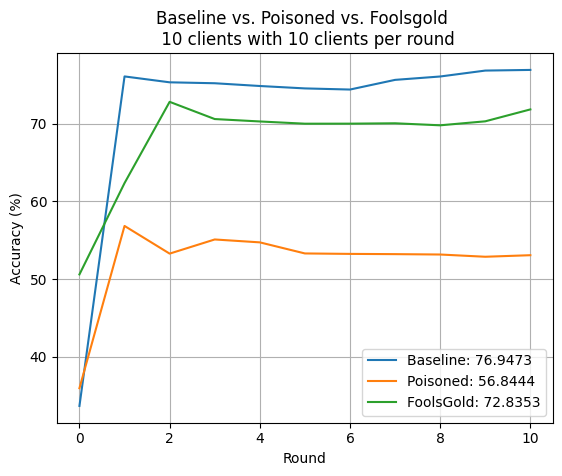

In [53]:
baseline_metrics = cast(list, history_baseline.metrics_centralized["accuracy"])
round = [data[0] for data in baseline_metrics]
acc_baseline = [100.0 * data[1] for data in baseline_metrics]

plt.plot(round, acc_baseline, label=f"Baseline: {max(acc_baseline):.4f}")

poisoned_metrics = cast(list, history_poisoned.metrics_centralized["accuracy"])
acc_poisoned = [100.0 * data[1] for data in poisoned_metrics]

plt.plot(round, acc_poisoned, label=f"Poisoned: {max(acc_poisoned):.4f}")

fg_metrics = cast(list, history_fg.metrics_centralized["accuracy"])
acc_fg = [100.0 * data[1] for data in fg_metrics]

plt.plot(round, acc_fg, label=f"FoolsGold: {max(acc_fg):.4f}")

plt.grid()
plt.ylabel("Accuracy (%)")
plt.xlabel("Round")
plt.legend()
plt.title("Baseline vs. Poisoned vs. Foolsgold \n 10 clients with 10 clients per round")